# Global Path Variables

In [ ]:
base_path = "drive/MyDrive/Medical Data/"
EDA = "drive/MyDrive/Medical Data/EDA/"
pre_processing = "drive/MyDrive/Medical Data/PreProcessing/"
vgg19 = "/content/drive/MyDrive/Medical Data/VGG19/"

# Import Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from tqdm import tqdm
import cv2
import gc

# Importing Deep learning Libraries
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import (InputLayer, BatchNormalization, Dropout, Flatten,
                                     Dense, Activation, MaxPool2D, GlobalAveragePooling2D,
                                     Conv2D, MaxPooling2D)
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback, ReduceLROnPlateau
from keras import optimizers, Input
from keras.utils import plot_model
from keras.applications.imagenet_utils import decode_predictions
from keras.optimizers import Adam, RMSprop
from keras.metrics import Precision, Recall, AUC
from keras.backend import clear_session

# Pretrained model preprocess
from keras.applications.vgg19 import preprocess_input as vgg19_preprocess
from keras.applications.inception_v3 import preprocess_input as inception_preprocess
from keras.applications.xception import preprocess_input as xception_preprocess
from keras.applications.resnet import preprocess_input as resnet50_preprocess

# Pretrained models
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet50


# Image read and show
import skimage.io
from skimage.io import imread, imshow

# Metrics
from sklearn.metrics import f1_score , recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

2.12.0


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Limit memory growth for the GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Load the Dataset from h5 file..


In [ ]:
# Load the data files
# def load_data(file_name):
#     data = np.load(file_name, allow_pickle = False)
#     images = data['image']
#     image_names = data['image_name']
#     image_labels = data['image_label']
#     return images, image_names, image_labels

# # Load train, test, and validation datasets
# train_images, train_names, train_labels = load_data(f'{base_path}Dataset5_raw_train.npz')
#test_images, test_names, test_labels = load_data(f'{base_path}Dataset5_raw_test.npz')
#val_images, val_names, val_labels = load_data(f'{base_path}Dataset5_raw_val.npz')


def load_hdf5_data(hdf5_path):
    f = h5py.File(hdf5_path, 'r')
    return f['image'], f['image_name'], f['image_label']

train_images, train_names, train_labels = load_hdf5_data(f'{base_path}Dataset5_raw_train.h5')
val_images, val_names, val_labels = load_hdf5_data(f'{base_path}Dataset5_raw_val.h5')
test_images, test_names, test_labels = load_hdf5_data(f'{base_path}Dataset5_raw_test.h5')

In [ ]:
print(f"train_images shape and dtype : {train_images.shape} , {train_images.dtype} and train_labels shape and dtype : {train_labels.shape} , {train_labels.dtype}")
print(f"val_images shape : {val_images.shape} and train_labels shape : {val_labels.shape}")
print(f"test_images shape : {test_images.shape} and train_labels shape : {test_labels.shape}")

train_images shape and dtype : (19610, 224, 224, 3) , float16 and train_labels shape and dtype : (19610, 1) , float64
val_images shape : (6534, 224, 224, 3) and train_labels shape : (6534, 1)
test_images shape : (6540, 224, 224, 3) and train_labels shape : (6540, 1)


In [ ]:
def get_label_counts(labels):
    # Convert the HDF5 dataset to a numpy array first
    labels_np = np.array(labels)

    # Get the unique labels and their counts
    unique_labels, counts = np.unique(labels_np, return_counts=True)

    # Create a dictionary of label to count
    label_counts = dict(zip(unique_labels, counts))

    return label_counts

train_label_counts = get_label_counts(train_labels)
val_label_counts = get_label_counts(val_labels)
test_label_counts = get_label_counts(test_labels)

print("Training label counts:", train_label_counts)
print("Validation label counts:", val_label_counts)
print("Test label counts:", test_label_counts)


Training label counts: {0.0: 2512, 1.0: 3607, 2.0: 6115, 3.0: 4438, 4.0: 2938}
Validation label counts: {0.0: 836, 1.0: 1202, 2.0: 2038, 3.0: 1479, 4.0: 979}
Test label counts: {0.0: 838, 1.0: 1203, 2.0: 2039, 3.0: 1480, 4.0: 980}


# Class Label to Disease Name Mapping Dict

In [ ]:
"""
COVID-19 :  4,189 : 0
Lung-Opacity : 6,012 : 1
Normal : 10,192 : 2
Viral Pneumonia : 7,397 : 3
Tuberculosis : 4,897 : 4
"""

Label_ClassName_Dict = {
    0 : "COVID-19",
    1 : "Lung-Opacity",
    2 : "Normal",
    3 : "Viral Pneumonia",
    4 : "Tuberculosis",
}

ClassName_Dict_Label  = {v: k for k, v in Label_ClassName_Dict.items()}

float32 0.08630371 0.7841797 (224, 224, 3) 3
float32 0.0 0.80371094 (224, 224, 3) 3
float32 0.003921509 1.0 (224, 224, 3) 3
float32 0.0 0.9135742 (224, 224, 3) 3
float32 0.1607666 0.8276367 (224, 224, 3) 3


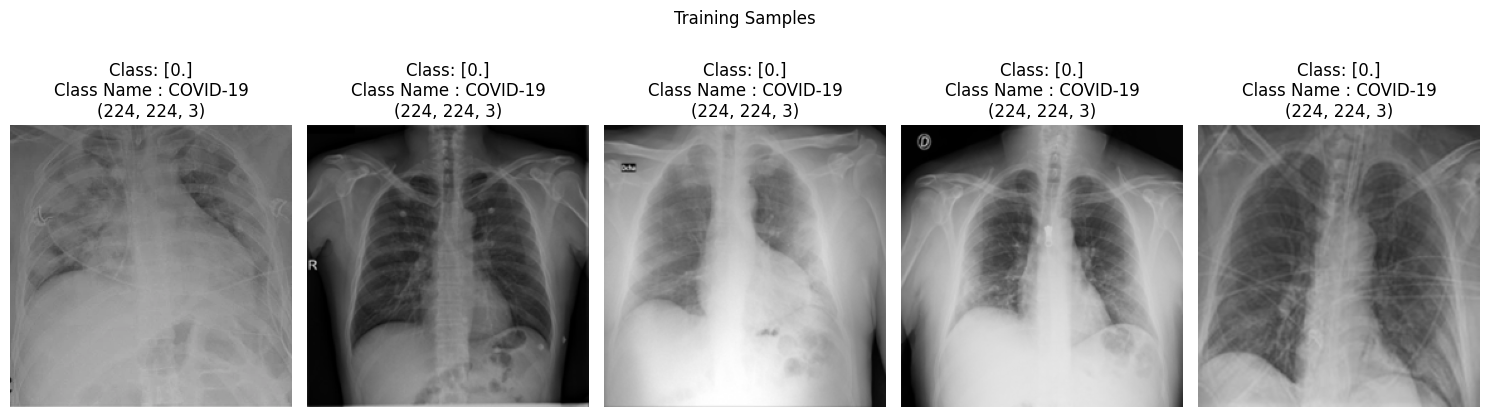

<Figure size 640x480 with 0 Axes>

In [ ]:
def display_samples(images, labels, path, num_samples=5, Type = "Training"):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        ax = plt.subplot(1, num_samples, i + 1)
        image = images[i]
        # Normalize the image if its values are not in the range [0, 1]
        # Convert the image to a suitable dtype
        if image.max() > 1:
            image = (image / 255.0).astype(np.float32)
        else:
            image = image.astype(np.float32)
        print(image.dtype, image.min(), image.max(), image.shape, len(image.shape))
        plt.imshow(image, cmap='gray' if len(image.shape) == 2 else None) # Use gray colormap if the image is grayscale
        plt.title(f'Class: {labels[i]}\n' + f'Class Name : {Label_ClassName_Dict[int(labels[i].squeeze())]}\n' + f"{image.shape}")
        plt.axis('off')

    plt.suptitle(f"{Type} Samples")
    plt.tight_layout()
    plt.show()
    plt.savefig(path)

display_samples(train_images, train_labels, f"{pre_processing}Image_Samples.png")

# Image Pre-processing
1. CLAHE with grid size of 15 and clip size of 2.
2. Image Sharpening with kernels.
3. Hybrid (CLAHE + Image Sharpening)

In [ ]:
"""
CLAHE
"""

# Function to apply CLAHE
def apply_clahe(img, grid_size=15, clip_limit=2.0):
    img = img.numpy()  # Convert tensor to numpy array
    img = img.astype(np.uint8)
    grid_size = int(grid_size)
    clahe = cv2.createCLAHE(clipLimit=float(clip_limit), tileGridSize=(grid_size, grid_size))
    img_clahe = np.zeros_like(img)
    for channel in range(3):
        img_clahe[..., channel] = clahe.apply(img[..., channel])
    return img_clahe

"""
Image Shapening
"""

# kernels = [[[ 0,-1, 0],[-1, 5,-1],[ 0,-1, 0]], # Basic Sharpening Kernel:
#            [[ 0, 1, 0],[ 1,-4, 1],[ 0, 1, 0]], # Laplacian Sharpening Kernel:
#            [[-1, 0,-1],[ 0, 8, 0],[-1, 0,-1]], # Diagonal Edge Sharpening:
#            [[-1,-1,-1],[-1, 9,-1],[-1,-1,-1]], # Exaggerated Sharpening:
#            [[ 1, 1, 1],[ 1,-7, 1],[ 1, 1, 1]], # Another variant of Laplacian:
# ]

kernels = {
    "Basic Sharpening Kernel" : np.array([[ 0,-1, 0],[-1, 5,-1],[ 0,-1, 0]]),
    "Laplacian Sharpening Kernel" : np.array([[ 0, 1, 0],[ 1,-4, 1],[ 0, 1, 0]]),
    "Diagonal Edge Sharpening" : np.array([[-1, 0,-1],[ 0, 8, 0],[-1, 0,-1]]) ,
    "Exaggerated Sharpening" : np.array([[-1,-1,-1],[-1, 9,-1],[-1,-1,-1]]),
    "Another variant of Laplacian" : np.array([[ 1, 1, 1],[ 1,-7, 1],[ 1, 1, 1]],) ,
}

# Function to sharpen image
def sharpen_image(img, kernel= kernels["Basic Sharpening Kernel"]):
    img = img.numpy()
    img = img.astype(np.uint8)
    kernel = np.array(kernel)
    return cv2.filter2D(img, -1, kernel)

"""
Pre-Process and Visualisation Functions
"""

# Apply CLAHE and sharpening transformations only to images
def preprocess_images(image, label):
    image = tf.py_function(apply_clahe, [image], tf.uint8)
    image = tf.py_function(sharpen_image, [image], tf.uint8)
    return image, label

# Apply CLAHE only to images
def preprocess_images_clahe(image, label, grid_size=15, clip_limit=2.0):
    image = tf.py_function(apply_clahe, [image, grid_size, clip_limit], tf.uint8)
    return image, label

# Apply sharpening transformations only to images
def preprocess_images_sharpen(image, label, kernel):
    image = tf.py_function(sharpen_image, [image, kernel], tf.uint8)
    return image, label

# Visualization function
def visualize_dataset(ds, title, path):
    samples = ds.take(5)
    # print(len(list(samples)))

    plt.figure(figsize=(15, 5))
    i = 0
    for image, label in samples:
        # print(int(label.numpy().squeeze()), label.numpy().shape , len(label.numpy()))
        # print(type(image), image.shape, len(image))
        #image = tf.image.convert_image_dtype(image, dtype=tf.uint8)
        image = image.numpy()
        if image.max() > 1:
            image = (image / 255.0).astype(np.float32)
        else:
            image = image.astype(np.float32)
        # print(image.dtype, image.min(), image.max(), image.shape, len(image.shape))
        plt.subplot(1, 5, i+1)
        plt.imshow(image)
        plt.title(f"Label: {Label_ClassName_Dict[int(label.numpy().squeeze())]}")
        plt.axis('off')
        i += 1
    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(path)
    plt.show()

def visualize_dataset_for_finetuning(ds, factors, title, path, Type = "Kernel", kernels = None):
    # Type = factor , clip limit
    plt.figure(figsize=(15, len(factors)*3))

    for i, factor in enumerate(factors):
        if Type == "Clip Limit":
            modified_ds = ds.map(lambda img, label: preprocess_images_clahe(img, label, grid_size=15, clip_limit=factor), num_parallel_calls=tf.data.experimental.AUTOTUNE)
        if Type == "Kernel":
            kernel_name = list(kernels.keys())[i]
            modified_ds = ds.map(lambda img, label: preprocess_images_sharpen(img, label, kernel= kernels[kernel_name]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
        if Type == "Grid Size":
            modified_ds = ds.map(lambda img, label: preprocess_images_clahe(img, label, grid_size = factor), num_parallel_calls=tf.data.experimental.AUTOTUNE)
        samples = modified_ds.take(5)

        for j, (image, label) in enumerate(samples):
            image = image.numpy()
            if image.max() > 1:
                image = (image / 255.0).astype(np.float32)
            else:
                image = image.astype(np.float32)

            plt.subplot(len(factors), 5, i*5 + j + 1)
            plt.imshow(image)
            plt.title(f"Label: {Label_ClassName_Dict[int(label.numpy().squeeze())]}\n{Type}: {factor}")
            if Type == "Kernel":
              plt.title(f"Label: {Label_ClassName_Dict[int(label.numpy().squeeze())]}\n{list(kernels.keys())[i]}")
            plt.axis('off')

    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(path)
    plt.show()

def rescale_image(img):
    return (img - img.min()) / (img.max() - img.min())

def plot_pixel_intensity_from_dataset(dataset):
    # Compute average pixel intensities
    avg_intensities = [img.numpy().mean() for img, _ in dataset]

    # Plot the histogram
    plt.hist(avg_intensities, bins=30)
    plt.legend()
    plt.title(f'Pixel Intensity Distribution.')
    plt.show()

## Create Tensorflow Datasets from HDF5 files.


In [ ]:
# Create a TF Dataset
with tf.device('/cpu:0'):
    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))

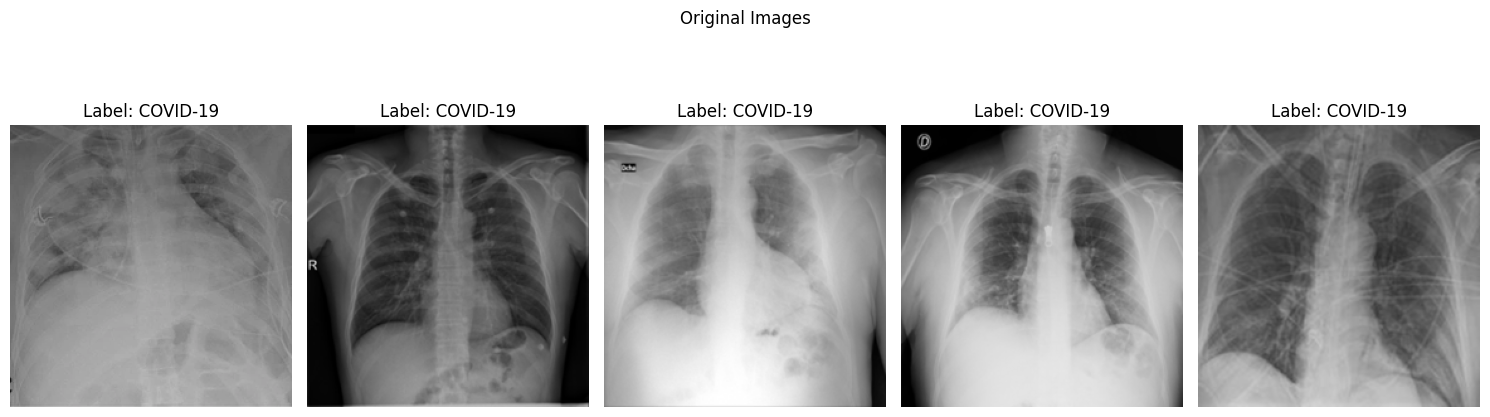

In [ ]:
# Display processed images with labels
visualize_dataset(train_dataset, "Original Images", f"{pre_processing}orig_images.png")

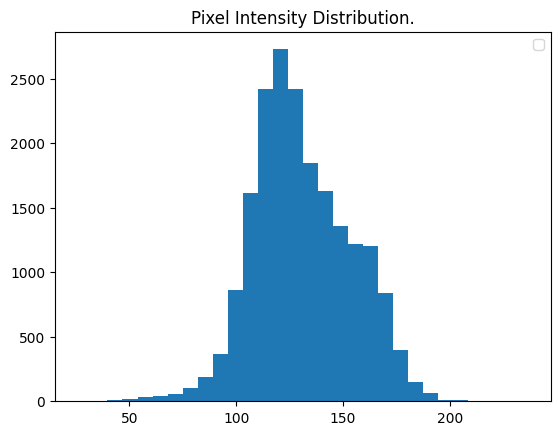

In [ ]:
# Use the function
plot_pixel_intensity_from_dataset(train_dataset)

## Experiments with CLAHE , Grid size = [0.5,1.0,1.5,2.0,2.5] and Clip size = 2


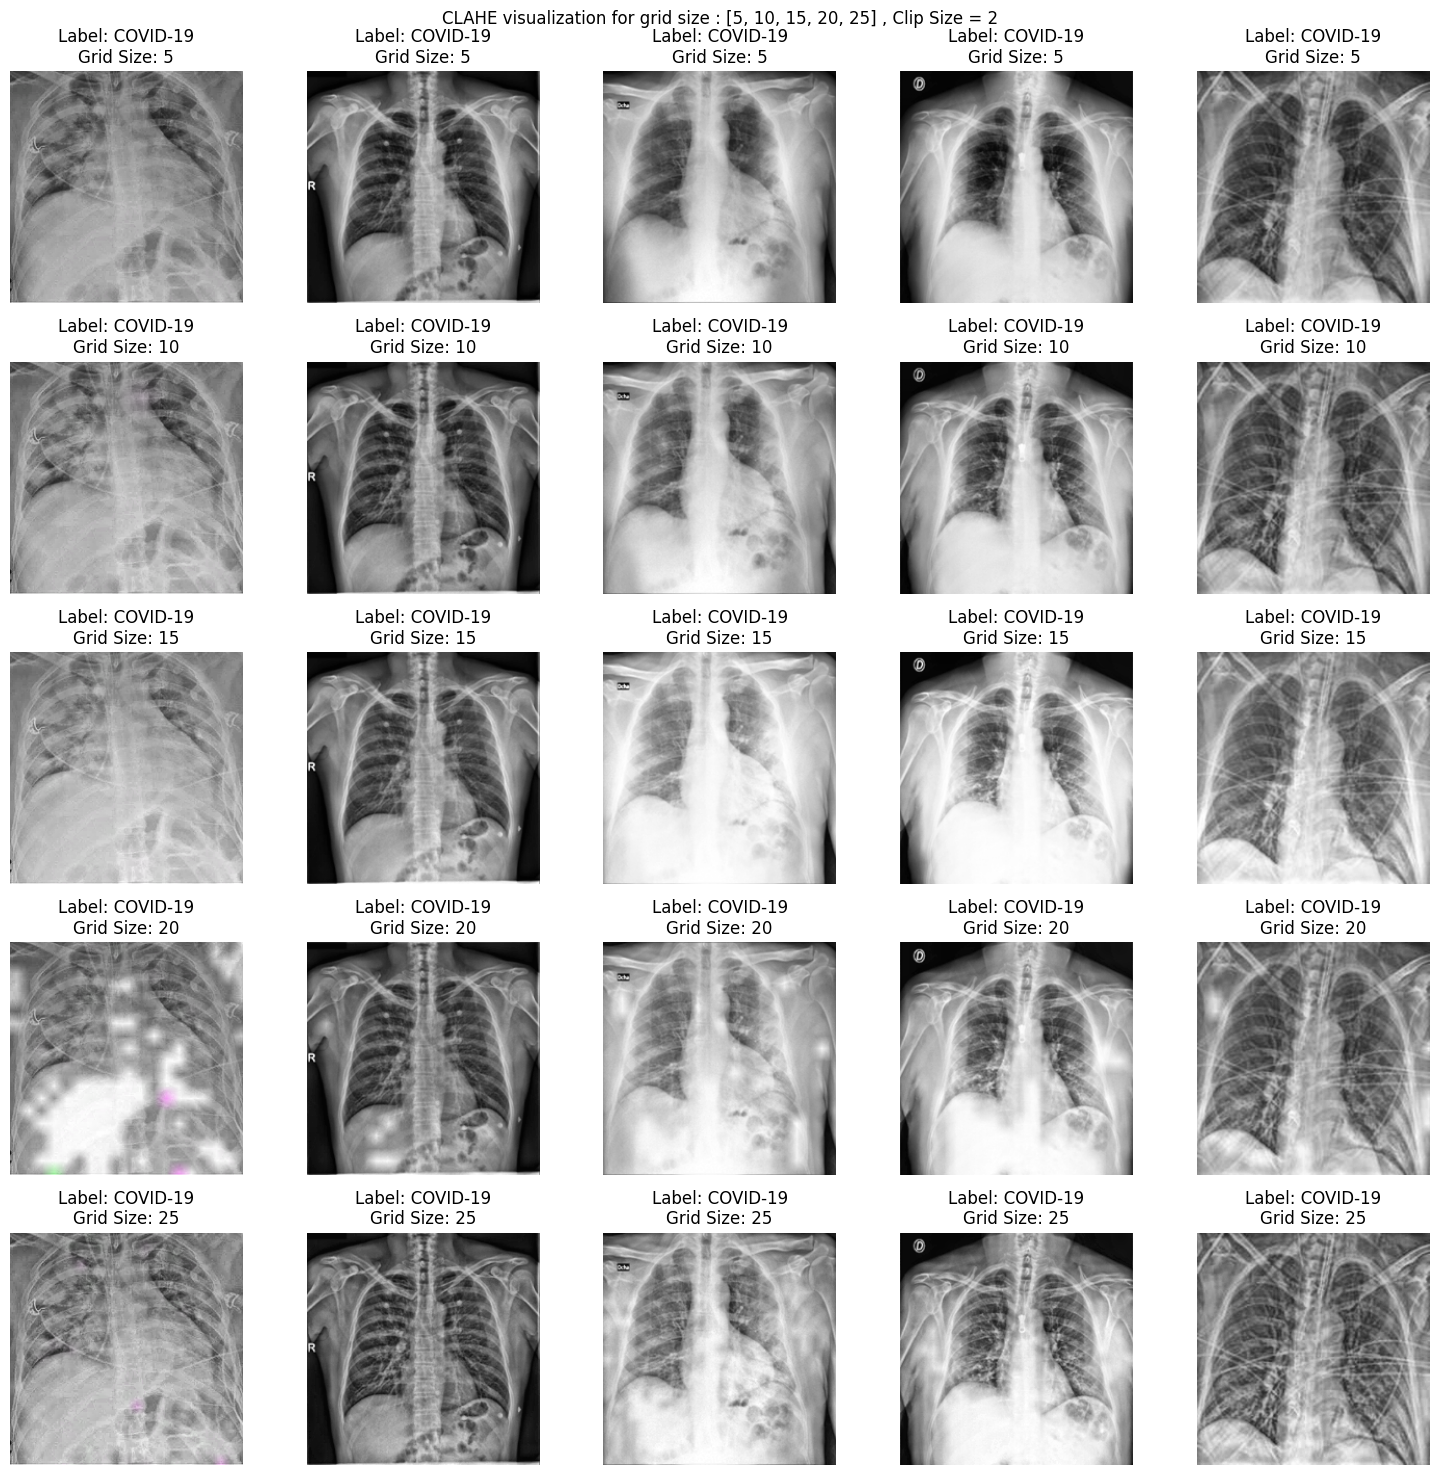

In [ ]:
visualize_dataset_for_finetuning(train_dataset, [5,10,15,20,25], f"CLAHE visualization for grid size : {[5, 10, 15, 20, 25]} , Clip Size = 2", f"{pre_processing}clahe_grid_size.png", Type = "Grid Size")

In [ ]:
visualize_dataset_for_finetuning(train_dataset, [0.5, 1.0,1.5,2.0,2.5,10], f"CLAHE visualization for clip size : {[0.5, 1,1.5,2,2.5]} Grid size = 15", f"{pre_processing}clahe_clip_size.png", Type = "Clip Limit")

Output hidden; open in https://colab.research.google.com to view.

## Experiments with Image sharpeninig , factor = [1,2,3,4,5]

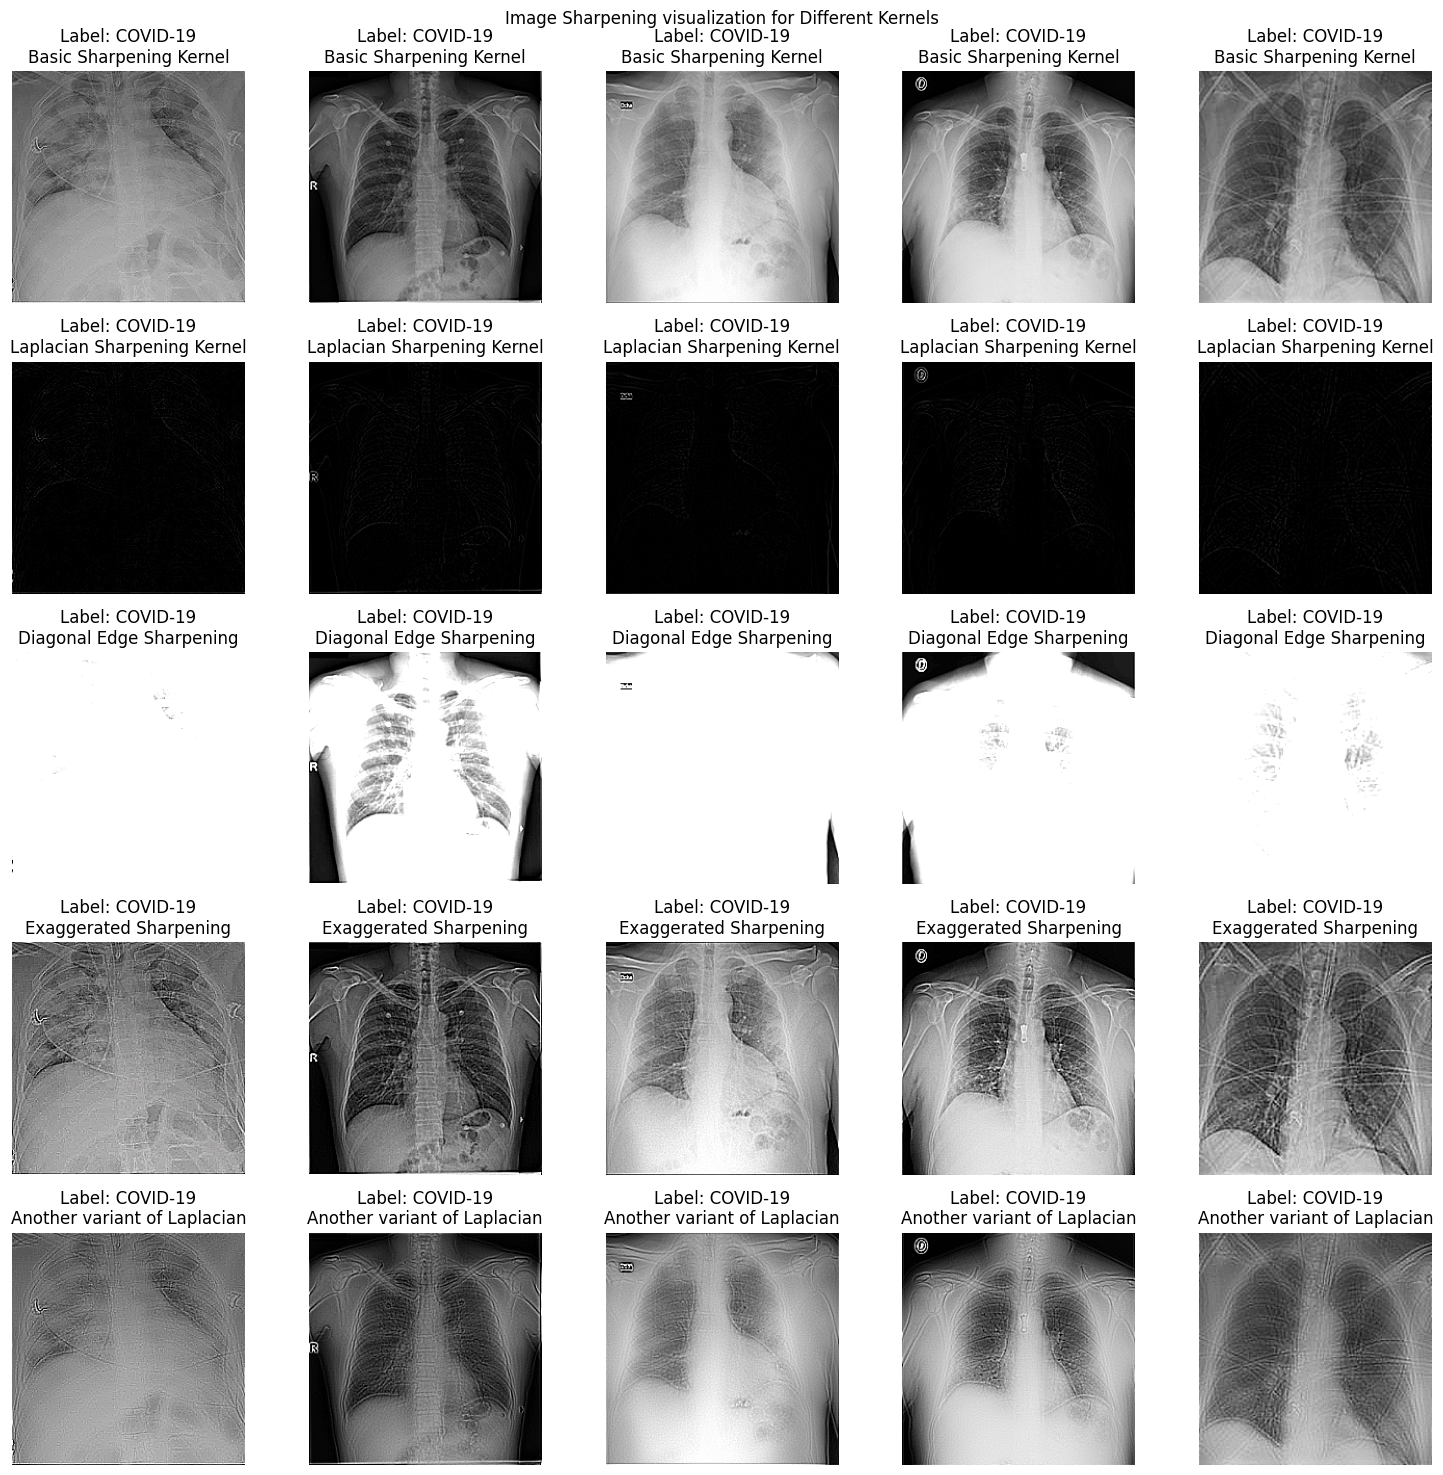

In [ ]:
visualize_dataset_for_finetuning(train_dataset, [1,2,3,4,5] , f"Image Sharpening visualization for Different Kernels", f"{pre_processing}image_sharpening.png", Type = "Kernel", kernels= kernels)

## Experiments with Hybrid , Clip Size = 2 , Grid Size = 15 , Image Sharpening kernels

Selected Kernel : Basic Sharpening Kernel


In [ ]:
train_dataset_clahe = train_dataset.map(preprocess_images_clahe, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
visualize_dataset_for_finetuning(train_dataset_clahe, [1,2,3,4,5], f"CLAHE (Clip Size = 2, Grid Size = 15) + Image Sharpening visualization for different Kernels", f"{pre_processing}clahe_image_sharpening.png", Type = "Kernel", kernels = kernels)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
del train_dataset_clahe

## Apply Pre-Processing

In [ ]:
# Create a TF Dataset for validation set and testing set.
with tf.device('/cpu:0'):
    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
    test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))

In [ ]:
with tf.device('/cpu:0'):
    # Training set Pre-Processing
    train_dataset_preprocessed = train_dataset.map(preprocess_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # Validation set Pre-Processing
    val_dataset_preprocessed = val_dataset.map(preprocess_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # Testing set Pre-Processing
    test_dataset_preprocessed = test_dataset.map(preprocess_images, num_parallel_calls=tf.data.experimental.AUTOTUNE)

<class 'tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset'>
<class 'tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset'>
<class 'tensorflow.python.data.ops.from_tensor_slices_op._TensorSliceDataset'>
<class 'tensorflow.python.data.ops.map_op._ParallelMapDataset'>
<class 'tensorflow.python.data.ops.map_op._ParallelMapDataset'>
<class 'tensorflow.python.data.ops.map_op._ParallelMapDataset'>


(224, 224, 3) (1,)
0 255 167.22386532738096
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([0.], shape=(1,), dtype=float64)


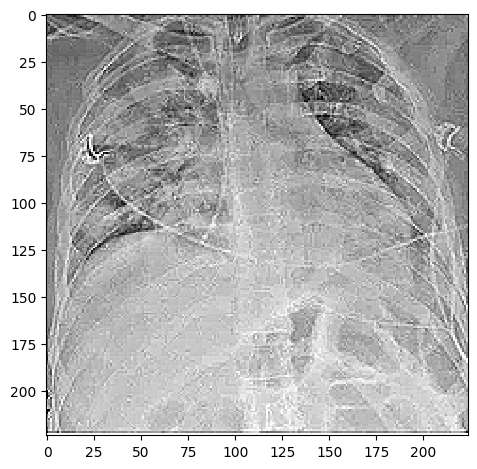

In [ ]:
# Testing all 3 datasets to check if they were loaded and pre-processed correctly.
print(type(train_dataset))
print(type(val_dataset))
print(type(test_dataset))

print(type(train_dataset_preprocessed))
print(type(val_dataset_preprocessed))
print(type(test_dataset_preprocessed))

print()
print()

for (img, label) in train_dataset_preprocessed.take(1):
  print(img.shape, label.shape)
  print(img.numpy().min(), img.numpy().max(), img.numpy().mean())
  print(type(label) , type(img))
  print(label)
  imshow(img.numpy())

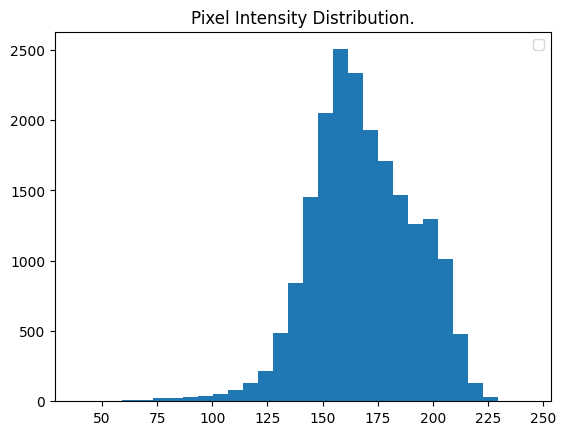

In [ ]:
# Use the function
plot_pixel_intensity_from_dataset(train_dataset_preprocessed)

# Set Seed

In [ ]:
Seed = 123
Batch_Size = 128
Image_Size = 224
num_classes = 5
np.random.seed(Seed)
tf.random.set_seed(Seed)

# Final Pre-Processing for Pre-trained models.

1. Vgg19 preprocess

*   scaling + 0 centering
*   Normalization

2. Repeated Fine Tuning



## pre process

In [ ]:
"""
1. vgg19 Pre Process
"""
# Scaling
def scaling(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

## Scaling and 0 centering

In [ ]:
with tf.device('/cpu:0'):
    train_dataset_scaled = train_dataset_preprocessed.map(lambda img, lbl: scaling(img,lbl), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_dataset_scaled = val_dataset_preprocessed.map(lambda img, lbl: scaling(img,lbl), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    test_dataset_scaled = test_dataset_preprocessed.map(lambda img, lbl: scaling(img,lbl), num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
print(type(train_dataset_scaled))
print(type(val_dataset_scaled))
print(type(test_dataset_scaled))

<class 'tensorflow.python.data.ops.map_op._ParallelMapDataset'>
<class 'tensorflow.python.data.ops.map_op._ParallelMapDataset'>
<class 'tensorflow.python.data.ops.map_op._ParallelMapDataset'>


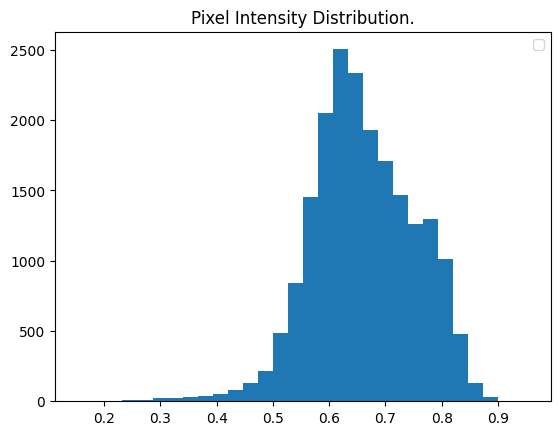

In [ ]:
plot_pixel_intensity_from_dataset(train_dataset_scaled)

In [ ]:
with tf.device('/cpu:0'):

    def accumulate_images(img, label):
        return tf.reduce_sum(img, axis=0), tf.shape(img)[0]

    # Map the accumulate function onto the dataset and reduce to get global sum and count
    accumulated_data = train_dataset_scaled.map(accumulate_images).reduce(
        (tf.zeros([224, 224, 3]), 0),
        lambda x, y: (x[0] + y[0], x[1] + y[1])
    )

    # Compute the mean
    mean_image = accumulated_data[0] / tf.cast(accumulated_data[1], tf.float32)


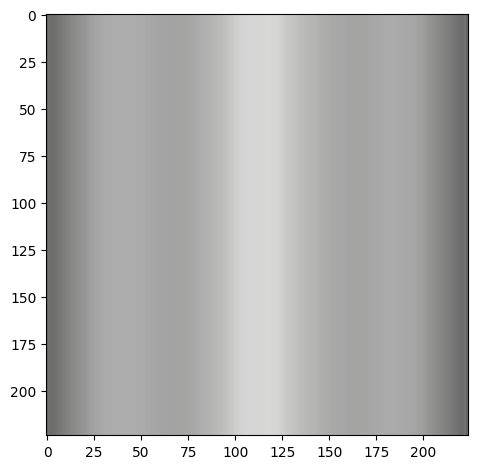

In [ ]:
imshow(mean_image.numpy())

In [ ]:
# Zero-centering
def zero_center(image, label):
    return image - mean_image, label

with tf.device('/cpu:0'):
      # Apply zero-centering to the datasets
      train_dataset_scaled_centered = train_dataset_scaled.map(zero_center, num_parallel_calls=tf.data.experimental.AUTOTUNE)
      val_dataset_scaled_centered = val_dataset_scaled.map(zero_center, num_parallel_calls=tf.data.experimental.AUTOTUNE)
      test_dataset_scaled_centered = test_dataset_scaled.map(zero_center, num_parallel_calls=tf.data.experimental.AUTOTUNE)


<class 'tensorflow.python.data.ops.map_op._ParallelMapDataset'>
<class 'tensorflow.python.data.ops.map_op._ParallelMapDataset'>
<class 'tensorflow.python.data.ops.map_op._ParallelMapDataset'>

(224, 224, 3) (1,)
-0.72095615 0.59653604 -0.005064371
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([0.], shape=(1,), dtype=float64)


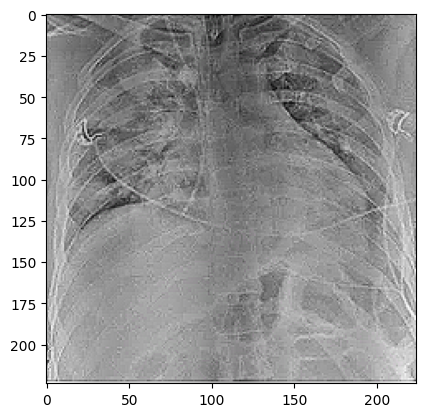

In [ ]:
print(type(train_dataset_scaled_centered))
print(type(val_dataset_scaled_centered))
print(type(test_dataset_scaled_centered))

print()

# Testing all 3 datasets to check if they were loaded and pre-processed correctly.
for (img, label) in train_dataset_scaled_centered.take(1):
  print(img.shape, label.shape)
  print(img.numpy().min(), img.numpy().max(), img.numpy().mean())
  print(type(label) , type(img))
  print(label)
  # imshow(img.numpy())

  img_rescaled = rescale_image(img.numpy())
  plt.imshow(img_rescaled)
  plt.show()

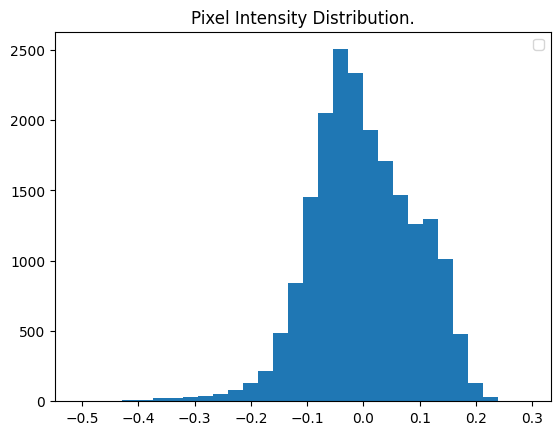

In [ ]:
plot_pixel_intensity_from_dataset(train_dataset_scaled_centered)

## Normalization

In [ ]:
total_images = 0
mean_sum = np.zeros([224, 224, 3])
squared_sum = np.zeros([224, 224, 3])

for images, _ in train_dataset_preprocessed:
    images = tf.cast(images, tf.float32) / 255.0  # Make sure the images are in float
    total_images += images.shape[0]
    mean_sum += tf.reduce_sum(images, axis=0).numpy()
    squared_sum += tf.reduce_sum(tf.square(images), axis=0).numpy()

dataset_mean = mean_sum / total_images
dataset_variance = (squared_sum / total_images) - np.square(dataset_mean)
dataset_std = np.sqrt(dataset_variance)

In [ ]:
print(dataset_mean.shape)
print()
print(dataset_std)

(224, 224, 3)

[[[0.36925483 0.36911577 0.36878282]
  [0.36409793 0.36391983 0.36348895]
  [0.34744809 0.34723742 0.3466687 ]
  ...
  [0.34641649 0.34625504 0.34582653]
  [0.36407118 0.36394778 0.3636263 ]
  [0.35985191 0.35973389 0.35944569]]

 [[0.36925483 0.36911577 0.36878282]
  [0.36409793 0.36391983 0.36348895]
  [0.34744809 0.34723742 0.3466687 ]
  ...
  [0.34641649 0.34625504 0.34582653]
  [0.36407118 0.36394778 0.3636263 ]
  [0.35985191 0.35973389 0.35944569]]

 [[0.36925483 0.36911577 0.36878282]
  [0.36409793 0.36391983 0.36348895]
  [0.34744809 0.34723742 0.3466687 ]
  ...
  [0.34641649 0.34625504 0.34582653]
  [0.36407118 0.36394778 0.3636263 ]
  [0.35985191 0.35973389 0.35944569]]

 ...

 [[0.36925483 0.36911577 0.36878282]
  [0.36409793 0.36391983 0.36348895]
  [0.34744809 0.34723742 0.3466687 ]
  ...
  [0.34641649 0.34625504 0.34582653]
  [0.36407118 0.36394778 0.3636263 ]
  [0.35985191 0.35973389 0.35944569]]

 [[0.36925483 0.36911577 0.36878282]
  [0.36409793 0.363919

In [ ]:
def normalize_img(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    normalized_image = (image - dataset_mean) / dataset_std
    return normalized_image, label

train_dataset_normalized = train_dataset_preprocessed.map(normalize_img)
val_dataset_normalized = val_dataset_preprocessed.map(normalize_img)
test_dataset_normalized = test_dataset_preprocessed.map(normalize_img)

<class 'tensorflow.python.data.ops.map_op._MapDataset'>
<class 'tensorflow.python.data.ops.map_op._MapDataset'>
<class 'tensorflow.python.data.ops.map_op._MapDataset'>

(224, 224, 3) (1,)
-3.9354355 1.6836705 -0.06820336
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([0.], shape=(1,), dtype=float64)


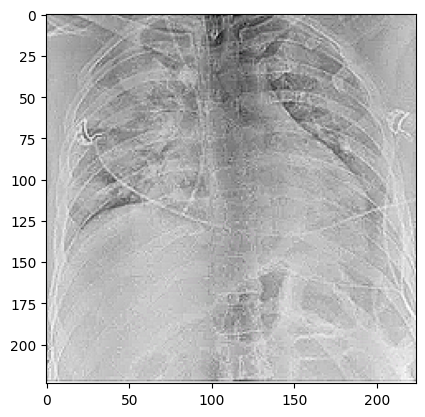

In [ ]:
print(type(train_dataset_normalized))
print(type(val_dataset_normalized))
print(type(test_dataset_normalized))

print()

# Testing all 3 datasets to check if they were loaded and pre-processed correctly.
for (img, label) in train_dataset_normalized.take(1):
  print(img.shape, label.shape)
  print(img.numpy().min(), img.numpy().max(), img.numpy().mean())
  print(type(label) , type(img))
  print(label)
  # imshow(img.numpy())

  img_rescaled = rescale_image(img.numpy())
  plt.imshow(img_rescaled)
  plt.show()

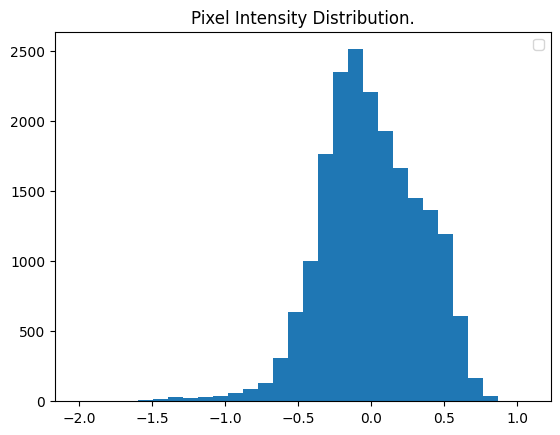

In [ ]:
plot_pixel_intensity_from_dataset(train_dataset_normalized)

## Shuffling the images

In [ ]:
BUFFER_SIZE = 19610
print(f"Buffer Size : {BUFFER_SIZE}")

# train_dataset_normalized = train_dataset_normalized.shuffle(BUFFER_SIZE)
train_dataset_scaled_centered = train_dataset_scaled_centered.shuffle(BUFFER_SIZE)

Buffer Size : 19610


In [ ]:
def plot_images(dataset, n_rows=2, n_cols=5):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5))

    i = 0
    for image, label in dataset.take(n_rows * n_cols):
        ax = axes[i // n_cols, i % n_cols]
        img_rescaled = rescale_image(image.numpy())
        ax.imshow(img_rescaled)
        # print(int(label.numpy().squeeze()))
        ax.set_title(Label_ClassName_Dict[int(label.numpy().squeeze())])
        ax.axis('off')
        i += 1

    plt.tight_layout()
    plt.show()

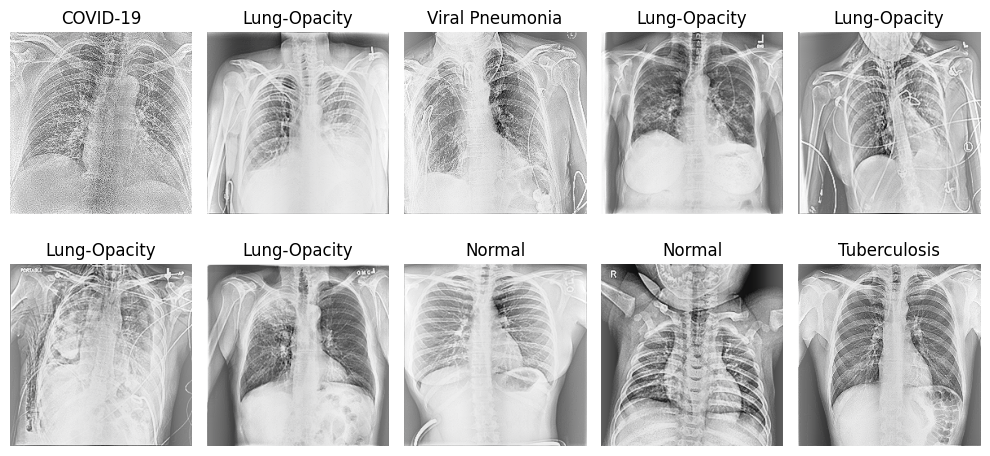

In [ ]:
plot_images(train_dataset_normalized)

## Data Loader and Batching.

In [ ]:
num_classes = 5

def one_hot_encode_batched(images, labels):
    labels = tf.cast(labels, tf.int32)
    labels = tf.one_hot(labels, depth=num_classes)
    labels = tf.squeeze(labels, axis = 1)  # Remove unnecessary dimensions
    return images, labels

In [ ]:
# Scaled , 0 centered dataset Batch and Prefetch
train_dataset_scaled_centered_batched_onehot = (train_dataset_scaled_centered
                                                # .shuffle(BUFFER_SIZE)
                                                .batch(Batch_Size)
                                                .map(one_hot_encode_batched, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                                                # .shuffle(BUFFER_SIZE//Batch_Size)
                                                .prefetch(tf.data.experimental.AUTOTUNE))

val_dataset_scaled_centered_batched_onehot = (val_dataset_scaled_centered
                                              # .shuffle(BUFFER_SIZE)
                                              .batch(Batch_Size)
                                              .map(one_hot_encode_batched, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                                              # .shuffle(BUFFER_SIZE//Batch_Size)
                                              .prefetch(tf.data.experimental.AUTOTUNE))

test_dataset_scaled_centered_batched_onehot = (test_dataset_scaled_centered
                                                # .shuffle(BUFFER_SIZE)
                                                .batch(Batch_Size)
                                                .map(one_hot_encode_batched, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                                                # .shuffle(BUFFER_SIZE//Batch_Size)
                                                .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
# Normalised dataset Batch and Prefetch
train_dataset_normalized_batched_onehot = (train_dataset_normalized
                                                # .shuffle(BUFFER_SIZE)
                                                .batch(Batch_Size)
                                                .map(one_hot_encode_batched, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                                                # .shuffle(BUFFER_SIZE//Batch_Size)
                                                .prefetch(tf.data.experimental.AUTOTUNE))

val_dataset_normalized_batched_onehot = (val_dataset_normalized
                                              # .shuffle(BUFFER_SIZE)
                                              .batch(Batch_Size)
                                              .map(one_hot_encode_batched, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                                              # .shuffle(BUFFER_SIZE//Batch_Size)
                                              .prefetch(tf.data.experimental.AUTOTUNE))

test_dataset_normalized_batched_onehot = (test_dataset_normalized
                                                # .shuffle(BUFFER_SIZE)
                                                .batch(Batch_Size)
                                                .map(one_hot_encode_batched, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                                                # .shuffle(BUFFER_SIZE//Batch_Size)
                                                .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
# with tf.device('/cpu:0'):
#     # Scaled , 0 centered dataset Batch
#     train_dataset_scaled_centered_batched = train_dataset_scaled_centered.batch(Batch_Size).prefetch(tf.data.experimental.AUTOTUNE)
#     val_dataset_scaled_centered_batched = val_dataset_scaled_centered.batch(Batch_Size).prefetch(tf.data.experimental.AUTOTUNE)
#     test_dataset_scaled_centered_batched = test_dataset_scaled_centered.batch(Batch_Size).prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# print(type(train_dataset_scaled_centered_batched))
# print(type(val_dataset_scaled_centered_batched))
# print(type(test_dataset_scaled_centered_batched))


In [ ]:
# with tf.device('/cpu:0'):
#     train_dataset_scaled_centered_batched_onehot = train_dataset_scaled_centered_batched.map(one_hot_encode_batched)
#     val_dataset_scaled_centered_batched_onehot = val_dataset_scaled_centered_batched.map(one_hot_encode_batched)
#     test_dataset_scaled_centered_batched_onehot = test_dataset_scaled_centered_batched.map(one_hot_encode_batched)


In [ ]:
# print(type(train_dataset_scaled_centered_batched_onehot))
# print(type(val_dataset_scaled_centered_batched_onehot))
# print(type(test_dataset_scaled_centered_batched_onehot))


In [ ]:
# train_dataset_scaled_centered_batched_onehot = train_dataset_scaled_centered_batched_onehot.prefetch(tf.data.experimental.AUTOTUNE)
# val_dataset_scaled_centered_batched_onehot = val_dataset_scaled_centered_batched_onehot.prefetch(tf.data.experimental.AUTOTUNE)
# test_dataset_scaled_centered_batched_onehot = test_dataset_scaled_centered_batched_onehot.prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
print(type(train_dataset_scaled_centered_batched_onehot))
print(type(val_dataset_scaled_centered_batched_onehot))
print(type(test_dataset_scaled_centered_batched_onehot))


<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


(64, 224, 224, 3) (64, 5)
-0.8487888 0.59653604 0.017453838
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([0. 0. 0. 0. 1.], shape=(5,), dtype=float32)


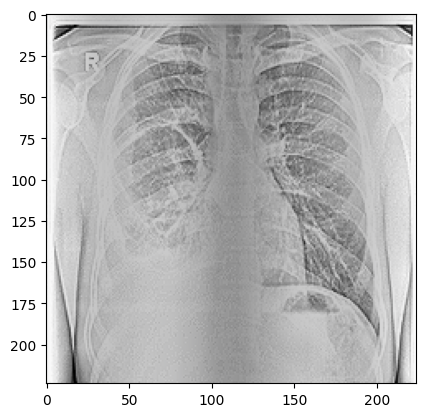

In [ ]:
# Testing all 3 datasets to check if they were loaded and pre-processed correctly.
for (img, label) in train_dataset_scaled_centered_batched_onehot.take(1):
  print(img.shape, label.shape)
  print(img.numpy().min(), img.numpy().max(), img.numpy().mean())
  print(type(label) , type(img))
  print(label[0])
  # imshow(img.numpy())

  img_rescaled = rescale_image(img.numpy()[0])
  plt.imshow(img_rescaled)
  plt.show()

In [ ]:
print(type(train_dataset_normalized_batched_onehot))
print(type(val_dataset_normalized_batched_onehot))
print(type(test_dataset_normalized_batched_onehot))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


(64, 224, 224, 3) (64, 5)
-5.017556 1.6836705 0.012156417
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([0. 0. 0. 1. 0.], shape=(5,), dtype=float32)


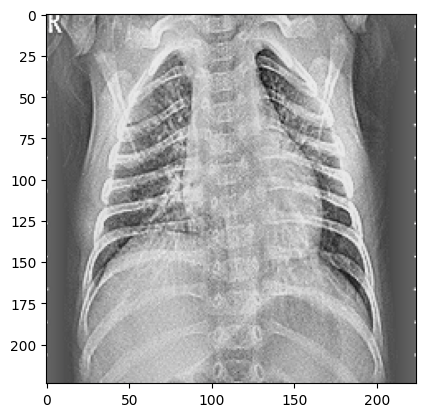

(64, 224, 224, 3) (64, 5)
-5.017556 1.6836705 0.021762962
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([0. 0. 1. 0. 0.], shape=(5,), dtype=float32)


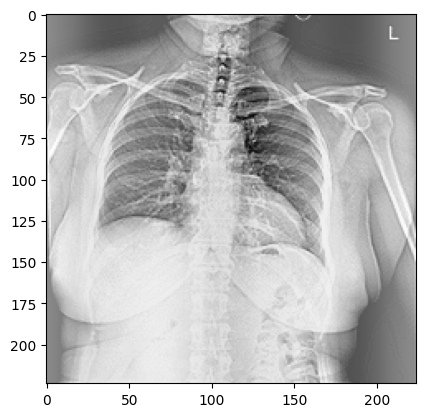

(64, 224, 224, 3) (64, 5)
-5.017556 1.6836705 -0.025074916
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([0. 0. 1. 0. 0.], shape=(5,), dtype=float32)


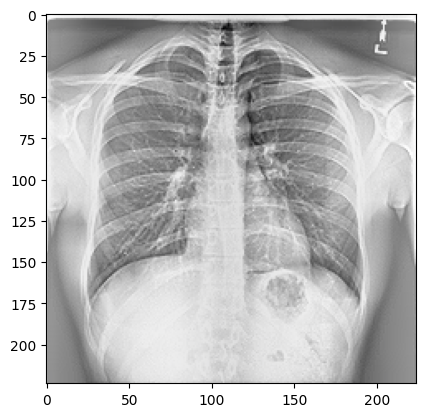

In [ ]:
# Testing all 3 datasets to check if they were loaded and pre-processed correctly.
for (img, label) in train_dataset_normalized_batched_onehot.take(1):
  print(img.shape, label.shape)
  print(img.numpy().min(), img.numpy().max(), img.numpy().mean())
  print(type(label) , type(img))
  print(label[0])
  # imshow(img.numpy())

  img_rescaled = rescale_image(img.numpy()[0])
  plt.imshow(img_rescaled)
  plt.show()

# Testing all 3 datasets to check if they were loaded and pre-processed correctly.
for (img, label) in val_dataset_normalized_batched_onehot.take(1):
  print(img.shape, label.shape)
  print(img.numpy().min(), img.numpy().max(), img.numpy().mean())
  print(type(label) , type(img))
  print(label[0])
  # imshow(img.numpy())

  img_rescaled = rescale_image(img.numpy()[0])
  plt.imshow(img_rescaled)
  plt.show()

for (img, label) in test_dataset_normalized_batched_onehot.take(1):
  print(img.shape, label.shape)
  print(img.numpy().min(), img.numpy().max(), img.numpy().mean())
  print(type(label) , type(img))
  print(label[0])
  # imshow(img.numpy())

  img_rescaled = rescale_image(img.numpy()[0])
  plt.imshow(img_rescaled)
  plt.show()

In [ ]:
# Initialize a list of zeros for each class
class_counts = [0, 0, 0, 0, 0]

# Iterate through the dataset
for _, labels in train_dataset_normalized_batched_onehot:
    # Sum across the batch dimension
    summed_labels = tf.reduce_sum(labels, axis=0)
    class_counts += summed_labels.numpy()

print("Class counts:", class_counts)

# Initialize a list of zeros for each class
class_counts = [0, 0, 0, 0, 0]

# Iterate through the dataset
for _, labels in val_dataset_normalized_batched_onehot:
    # Sum across the batch dimension
    summed_labels = tf.reduce_sum(labels, axis=0)
    class_counts += summed_labels.numpy()

print("Class counts:", class_counts)

# Initialize a list of zeros for each class
class_counts = [0, 0, 0, 0, 0]

# Iterate through the dataset
for _, labels in test_dataset_normalized_batched_onehot:
    # Sum across the batch dimension
    summed_labels = tf.reduce_sum(labels, axis=0)
    class_counts += summed_labels.numpy()

print("Class counts:", class_counts)

"""
Training label counts: {0.0: 2512, 1.0: 3607, 2.0: 6115, 3.0: 4438, 4.0: 2938}
Validation label counts: {0.0: 836, 1.0: 1202, 2.0: 2038, 3.0: 1479, 4.0: 979}
Test label counts: {0.0: 838, 1.0: 1203, 2.0: 2039, 3.0: 1480, 4.0: 980}
"""

Class counts: [2512. 3607. 6115. 4438. 2938.]
Class counts: [ 836. 1202. 2038. 1479.  979.]
Class counts: [ 838. 1203. 2039. 1480.  980.]


'\nTraining label counts: {0.0: 2512, 1.0: 3607, 2.0: 6115, 3.0: 4438, 4.0: 2938}\nValidation label counts: {0.0: 836, 1.0: 1202, 2.0: 2038, 3.0: 1479, 4.0: 979}\nTest label counts: {0.0: 838, 1.0: 1203, 2.0: 2039, 3.0: 1480, 4.0: 980}\n'

In [ ]:
# Initialize a list of zeros for each class
class_counts = [0, 0, 0, 0, 0]

# Iterate through the dataset
for _, labels in train_dataset_scaled_centered_batched_onehot:
    # Sum across the batch dimension
    summed_labels = tf.reduce_sum(labels, axis=0)
    class_counts += summed_labels.numpy()

print("Class counts:", class_counts)

# Initialize a list of zeros for each class
class_counts = [0, 0, 0, 0, 0]

# Iterate through the dataset
for _, labels in val_dataset_scaled_centered_batched_onehot:
    # Sum across the batch dimension
    summed_labels = tf.reduce_sum(labels, axis=0)
    class_counts += summed_labels.numpy()

print("Class counts:", class_counts)

# Initialize a list of zeros for each class
class_counts = [0, 0, 0, 0, 0]

# Iterate through the dataset
for _, labels in test_dataset_scaled_centered_batched_onehot:
    # Sum across the batch dimension
    summed_labels = tf.reduce_sum(labels, axis=0)
    class_counts += summed_labels.numpy()

print("Class counts:", class_counts)

Class counts: [2512. 3607. 6115. 4438. 2938.]
Class counts: [ 836. 1202. 2038. 1479.  979.]
Class counts: [ 838. 1203. 2039. 1480.  980.]


In [ ]:
def one_hot_to_class(label_one_hot):
    return np.argmax(label_one_hot, axis=-1)

153


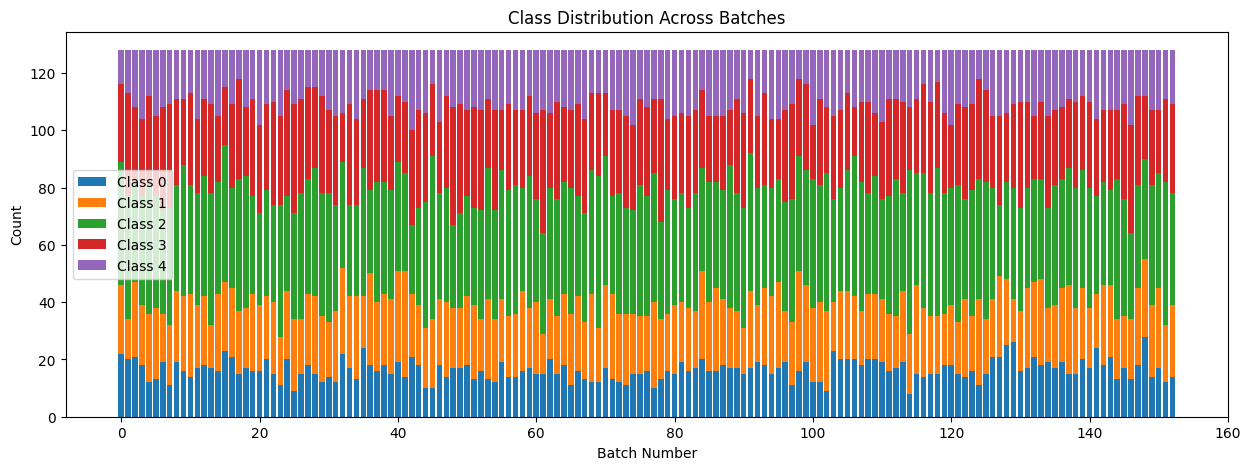

In [ ]:
batch_distributions = []
num_batches = BUFFER_SIZE // Batch_Size
print(num_batches)

# Iterate through batches
for _, labels in train_dataset_normalized_batched_onehot.take(num_batches):  # Adjust the number of batches as per your needs
    labels_class = one_hot_to_class(labels.numpy())
    batch_distribution = np.bincount(labels_class, minlength=5)  # Assuming 5 classes, adjust if different
    batch_distributions.append(batch_distribution)

# Convert to numpy array for easier indexing
batch_distributions = np.array(batch_distributions)

# Plotting
fig, ax = plt.subplots(figsize=(15, 5))
for class_idx in range(5):  # Assuming 5 classes
    ax.bar(np.arange(len(batch_distributions)), batch_distributions[:, class_idx],
           bottom=np.sum(batch_distributions[:, :class_idx], axis=1), label=f'Class {class_idx}')

ax.set_xlabel('Batch Number')
ax.set_ylabel('Count')
ax.set_title('Class Distribution Across Batches')
ax.legend()
plt.show()

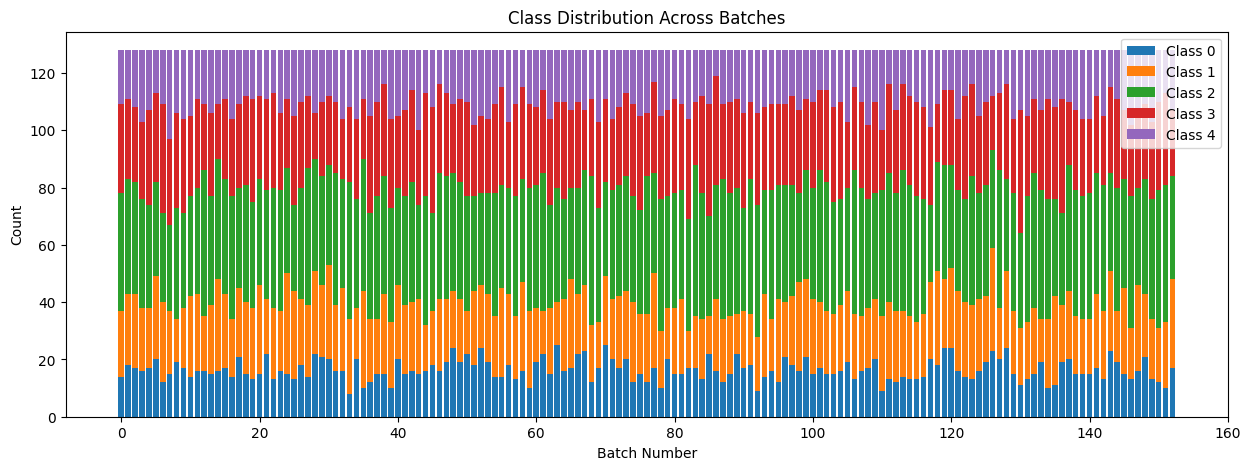

In [ ]:
batch_distributions = []

# Iterate through batches
for _, labels in train_dataset_scaled_centered_batched_onehot.take(num_batches):  # Adjust the number of batches as per your needs
    labels_class = one_hot_to_class(labels.numpy())
    batch_distribution = np.bincount(labels_class, minlength=5)  # Assuming 5 classes, adjust if different
    batch_distributions.append(batch_distribution)

# Convert to numpy array for easier indexing
batch_distributions = np.array(batch_distributions)

# Plotting
fig, ax = plt.subplots(figsize=(15, 5))
for class_idx in range(5):  # Assuming 5 classes
    ax.bar(np.arange(len(batch_distributions)), batch_distributions[:, class_idx],
           bottom=np.sum(batch_distributions[:, :class_idx], axis=1), label=f'Class {class_idx}')

ax.set_xlabel('Batch Number')
ax.set_ylabel('Count')
ax.set_title('Class Distribution Across Batches')
ax.legend()
plt.show()

## Fine Tuning train_dataset_vgg19_scaled_batched_onehot Dataset.


In [ ]:
def Confusion_Matrix_Heatmap(y_test,y_pred,class_Names, fName, ModelName):
    #Plot the confusion matrix to understand the classification in detail
    CM = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    ax = sns.heatmap(CM, cmap='Greens', annot=True, fmt='d', xticklabels=class_Names, yticklabels=class_Names)
    plt.title(f'Disease Diagnosis from CXR images - {ModelName}')
    plt.xlabel('Prediction')
    plt.ylabel('Truth')
    plt.savefig(f"{vgg19}{fName}")
    #plt.show(ax)

# Plot Evaluation Metrics
# sns.set_style('darkgrid')
#plt.style.use('fivethirtyeight')
def Eval_Plot(acc,val_acc, loss,val_loss, auc, val_auc, precision, val_precision, path, title):

    fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize= (20,5))
    fig.suptitle(f"{title}\n", fontsize = 15)

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy', fontsize = 15)
    ax1.set_xlabel('Epochs', fontsize = 15)
    ax1.set_ylabel('Accuracy', fontsize = 15)
    ax1.legend(['Training', 'Validation'], fontsize = 15)


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss', fontsize = 15)
    ax2.set_xlabel('Epochs', fontsize = 15)
    ax2.set_ylabel('Loss', fontsize = 15)
    ax2.legend(['Training', 'Validation'], fontsize = 15)

    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC', fontsize = 15)
    ax3.set_xlabel('Epochs', fontsize = 15)
    ax3.set_ylabel('AUC', fontsize = 15)
    ax3.legend(['Training', 'Validation'], fontsize = 15)

    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision', fontsize = 15)
    ax4.set_xlabel('Epochs', fontsize = 15)
    ax4.set_ylabel('Precision', fontsize = 15)
    ax4.legend(['Training', 'Validation'], fontsize = 15)

    plt.savefig(f"{vgg19}{path}")
    #plt.show()

In [ ]:
ClassName_Dict_Label

{'COVID-19': 0,
 'Lung-Opacity': 1,
 'Normal': 2,
 'Viral Pneumonia': 3,
 'Tuberculosis': 4}

In [ ]:
# GCW : Global Class Based Weighting
total_samples = 2512 + 3607 + 6115 + 4438 + 2938

# Calculate the global class-based weights
weights = {
    'COVID-19':  total_samples / (num_classes * 2512),
    'Lung-Opacity':  total_samples / (num_classes * 3607),
    'Normal':  total_samples / (num_classes * 6115),
    'Viral Pneumonia':  total_samples / (num_classes * 4438),
    'Tuberculosis':  total_samples / (num_classes * 2938)
}

int_weights = {ClassName_Dict_Label[key]: value for key, value in weights.items()}
print(int_weights)

{0: 1.5613057324840764, 1: 1.0873301912947047, 2: 0.6413736713000817, 3: 0.8837314105452907, 4: 1.334921715452689}


In [ ]:
weight_for_class_0 = total_samples / (5 * 2512)
weight_for_class_1 = total_samples / (5 * 3607)
weight_for_class_2 = total_samples / (5 * 6115)
weight_for_class_3 = total_samples / (5 * 4438)
weight_for_class_4 = total_samples / (5 * 2938)

print(weight_for_class_0 , weight_for_class_1 , weight_for_class_2 , weight_for_class_3 , weight_for_class_4)

1.5613057324840764 1.0873301912947047 0.6413736713000817 0.8837314105452907 1.334921715452689


In [ ]:
# def compute_sample_weights_py(labels):
#     # Convert one-hot labels back to integer labels using numpy
#     int_labels = np.argmax(labels.numpy(), axis=-1)

#     # Map integer labels to their corresponding weights using numpy operations
#     sample_weights = np.array([int_weights[label] for label in int_labels], dtype=np.float32)

#     return sample_weights

# def compute_sample_weights(images, labels):
#     # Use tf.py_function to compute the sample weights using native Python/numpy operations
#     sample_weights = tf.py_function(func=compute_sample_weights_py, inp=[labels], Tout=tf.float32)

#     # Ensure that sample_weights has the correct shape
#     sample_weights.set_shape(labels.shape[0])

#     return images, labels, sample_weights


# with tf.device('/cpu:0'):
#     train_dataset_scaled_centered_batched_onehot = train_dataset_scaled_centered_batched_onehot.map(compute_sample_weights)

In [ ]:
steps_per_epoch = total_samples // Batch_Size
print('steps per epoch: ',steps_per_epoch + 1)

steps per epoch:  307


In [ ]:
# scaled and 0 centered.
for images, labels in train_dataset_scaled_centered_batched_onehot.take(1):
    print("Images shape:", images.shape)
    print("Images dtype:", images.dtype)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    print(labels[0])

print(type(train_dataset_scaled_centered_batched_onehot))

Images shape: (64, 224, 224, 3)
Images dtype: <dtype: 'float32'>
Labels shape: (64, 5)
Labels dtype: <dtype: 'float32'>
tf.Tensor([0. 1. 0. 0. 0.], shape=(5,), dtype=float32)
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [ ]:
# scaled and 0 centered.
for images, labels in val_dataset_scaled_centered_batched_onehot.take(1):
    print("Images shape:", images.shape)
    print("Images dtype:", images.dtype)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)

Images shape: (64, 224, 224, 3)
Images dtype: <dtype: 'float32'>
Labels shape: (64, 5)
Labels dtype: <dtype: 'float32'>


In [ ]:
# scaled and 0 centered.
for images, labels in train_dataset_normalized_batched_onehot.take(1):
    print("Images shape:", images.shape)
    print("Images dtype:", images.dtype)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    print(labels[0])

print(type(train_dataset_normalized_batched_onehot))

Images shape: (64, 224, 224, 3)
Images dtype: <dtype: 'float32'>
Labels shape: (64, 5)
Labels dtype: <dtype: 'float32'>
tf.Tensor([0. 0. 1. 0. 0.], shape=(5,), dtype=float32)
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [ ]:
# scaled and 0 centered.
for images, labels in val_dataset_normalized_batched_onehot.take(1):
    print("Images shape:", images.shape)
    print("Images dtype:", images.dtype)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    print(labels[0])

print(type(val_dataset_normalized_batched_onehot))

Images shape: (64, 224, 224, 3)
Images dtype: <dtype: 'float32'>
Labels shape: (64, 5)
Labels dtype: <dtype: 'float32'>
tf.Tensor([0. 0. 1. 0. 0.], shape=(5,), dtype=float32)
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


## Delete un-necessary Files to free up System Ram.

In [ ]:
del dataset_mean , dataset_std, dataset_variance
del mean_image, mean_sum , squared_sum
del test_images, test_dataset, test_dataset_normalized, test_dataset_preprocessed, test_dataset_scaled, test_dataset_scaled_centered
del train_images, train_dataset, train_dataset_normalized, train_dataset_preprocessed, train_dataset_scaled, train_dataset_scaled_centered
del val_images, val_dataset, val_dataset_normalized, val_dataset_preprocessed, val_dataset_scaled, val_dataset_scaled_centered
del test_labels, train_labels, val_labels

In [ ]:
del train_names, val_names, test_names
gc.collect()

0

## Testing the pre processed dataset with a simple model.

In [ ]:
from keras import backend as K
K.clear_session()

In [ ]:
def baseline(input_shape= (224,224,3), num_classes=5):
    inputs = Input(shape=input_shape)

    # First convolutional block
    x = Conv2D(64, 3, padding='same')(inputs)
    x = Activation("relu")(x)

    x = Conv2D(64, 3, padding='same')(x)
    x = Activation("relu")(x)

    x = MaxPooling2D()(x)
    x = Dropout(0.25)(x)

    # Second convolutional block
    x = Conv2D(128, 3, padding='same')(x)
    x = Activation("relu")(x)

    x = Conv2D(128, 3, padding='same')(x)
    x = Activation("relu")(x)

    x = MaxPooling2D()(x)
    x = Dropout(0.25)(x)

    # Third convolutional block
    x = Conv2D(256, 3, padding='same')(x)
    x = Activation("relu")(x)

    x = Conv2D(256, 3, padding='same')(x)
    x = Activation("relu")(x)

    x = MaxPooling2D()(x)
    x = Dropout(0.25)(x)

    # Fully connected layers
    x = Flatten()(x)
    x = Dense(512)(x)
    x = Activation("relu")(x)

    x = Dropout(0.5)(x)
    x = Dense(256)(x)
    x = Activation("relu")(x)

    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
with tf.device('/gpu:0'):
    # Initializing and compiling the model
    model = baseline()

    keras.utils.plot_model(model, show_shapes=True)
    model.summary()

    initial_learning_rate = 0.0001
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate, decay_steps=1530, decay_rate=0.96, staircase=True,
    )
    epochs = 50

# with tf.device('/gpu:0'):
    model.compile(
        optimizer=Adam(learning_rate=lr_schedule),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    # with tf.device('/gpu:0'):
    history = model.fit(
        train_dataset_scaled_centered_batched_onehot,
        validation_data= val_dataset_scaled_centered_batched_onehot,
        epochs=epochs,
        verbose = 1,
        class_weight=int_weights,
    )

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 activation (Activation)     (None, 224, 224, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 activation_1 (Activation)   (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                             

In [ ]:
# Getting predictions
predictions = model.predict(test_dataset_scaled_centered_batched_onehot)
y_pred = predictions.argmax(axis=-1)

# Retrieving labels from dataset
y_labels_list = []
for _, labels in test_dataset_scaled_centered_batched_onehot:
    # Here, we're assuming that the labels are one-hot encoded
    # So, we get the integer label for each sample in the batch
    y_labels_list.append(tf.argmax(labels, axis=-1))

# Stacking batches together
y_label = tf.concat(y_labels_list, axis=0).numpy()

# Retrieve class names from the ClassName_Dict_Label
class_Names = [class_name for class_name, _ in sorted(ClassName_Dict_Label.items(), key=lambda item: item[1])]

52/52 [==============================] - 22s 400ms/step


In [ ]:
assert y_pred.shape == y_label.shape

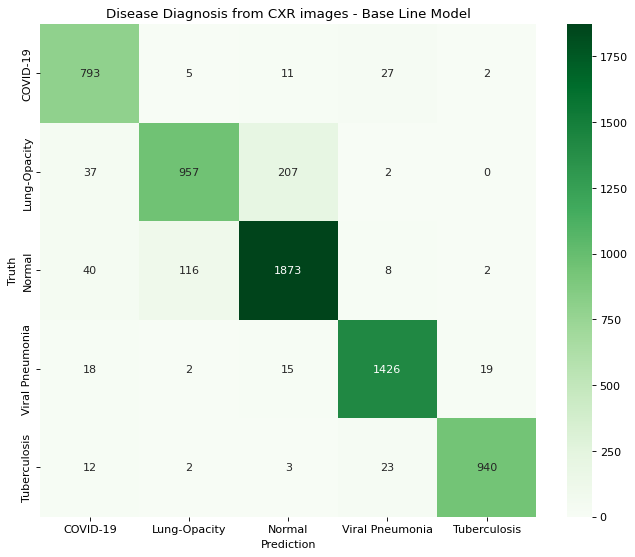

In [ ]:
Confusion_Matrix_Heatmap(y_label, y_pred, class_Names, f"HeatMap_Test.png", "Base Line Model")

In [ ]:
print(classification_report(y_label, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91       838
           1       0.88      0.80      0.84      1203
           2       0.89      0.92      0.90      2039
           3       0.96      0.96      0.96      1480
           4       0.98      0.96      0.97       980

    accuracy                           0.92      6540
   macro avg       0.92      0.92      0.92      6540
weighted avg       0.92      0.92      0.92      6540



In [ ]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_label, y_pred)

# Calculate class-specific accuracy
class_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

print(class_accuracy)

[0.94630072 0.79551122 0.91858754 0.96351351 0.95918367]


### Scores

In [ ]:
scores_VGG19 = model.evaluate(test_dataset_scaled_centered_batched_onehot)

52/52 [==============================] - 21s 409ms/step - loss: 0.5304 - accuracy: 0.9157


## Model Save

In [ ]:
model.save(f"{base_path}Base_line.h5")